# Project4 - Deep Lerning

## Image Classification


---
## 데이터 설명 - Stanford Cars Dataset (1.85 GB)

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

196 class의 (차종)

8,144 개의 train 이미지 

8,041 개의 test 이미지

총 16,185 개의 이미지로 구성


* 

주어진 데이터는 바운딩 박스의 좌표 데이터도 함께 주어졌다. 따라서 전처리로 선행되어야 할 바운딩 처리는 생략하고 진행한다.

---

##Data set 정보
- train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
- train - Train 이미지 파일
- test - Test 이미지 파일

---

## 목표 

1. 이미지에서 자동차 인식

2. 구분된 자동차의 차종 분류 예측  
   (test 의 class 가 target이 된다.)

---


In [1]:
import os
import gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ## 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive/')

### 파일 로드 및 확인

In [3]:
DATA_PATH = 'E:/coding/Stanford Cars Dataset/car_data/car_data'
os.listdir(DATA_PATH)

['class.csv',
 'sample_submission.csv',
 'sample_submission2.csv',
 'test',
 'test.csv',
 'test_crop',
 'test_crop.zip',
 'test_dj',
 'test_dj.csv',
 'test_폴더',
 'train',
 'train.csv',
 'train_crop',
 'train_crop.zip',
 'train_폴더']

In [48]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# IMG_SIZE
img_size = (224, 224)

In [5]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [6]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,00001.jpg,30,52,246,147
1,00002.jpg,100,19,576,203
2,00003.jpg,51,105,968,659
3,00004.jpg,67,84,581,407
4,00005.jpg,140,151,593,339


In [7]:
df_class.head() 

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [8]:
df_class[df_class['id'] == 32]

,id,name
31,32,BMW X5 SUV 2007


In [9]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


## 파일 실제 확인

In [10]:
## 파일 총 길이 체크 (test = 8041)
len(os.listdir(TEST_IMG_PATH))

8041

In [11]:
## 파일 총 길이 체크 (train = 8144)
len(os.listdir(TRAIN_IMG_PATH))

8144

In [12]:
## class 종류 
len(df_class)

196

In [13]:
## train 파일의 class 종류 
df_train['class'].nunique()

196

In [14]:
# ## 파일 업로드 오류 찾기 (test)
# a1 = os.listdir(TEST_IMG_PATH)

# for i in range(0,8100):
#     a1.sort()
#     if int(a1[i][0:5]) == i+1:
#         pass
#     else:
#         print(i,int(a1[i][0:5]),'Flas')
#         break

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


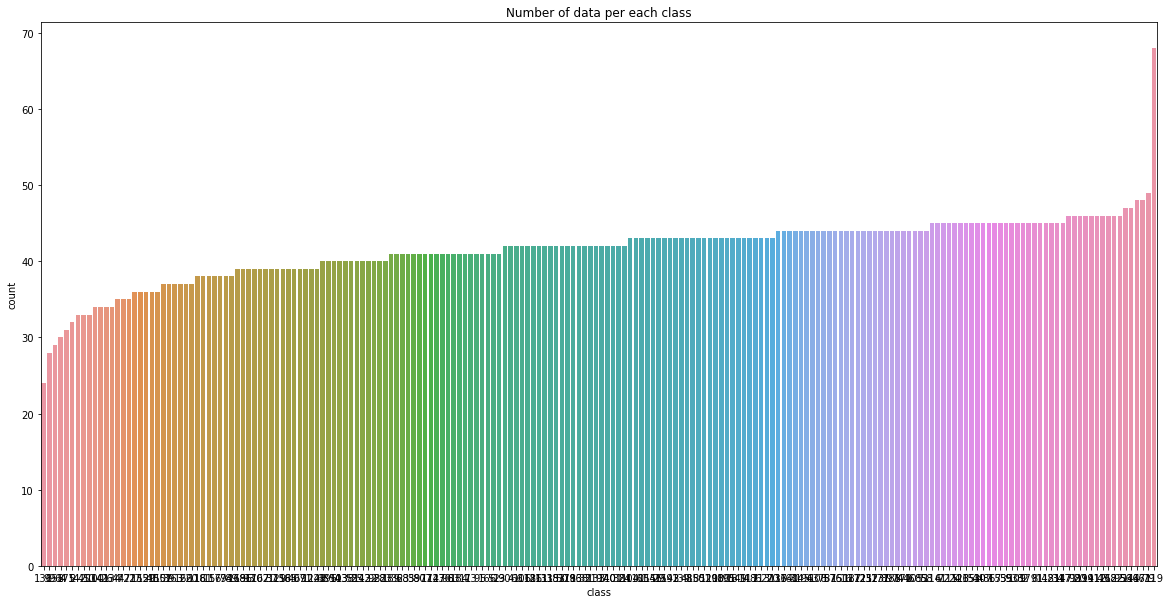

In [15]:
## 클래스 분포 확인

plt.figure(figsize=(20, 10))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

## 이미지 확인

In [16]:
import PIL
from PIL import ImageDraw

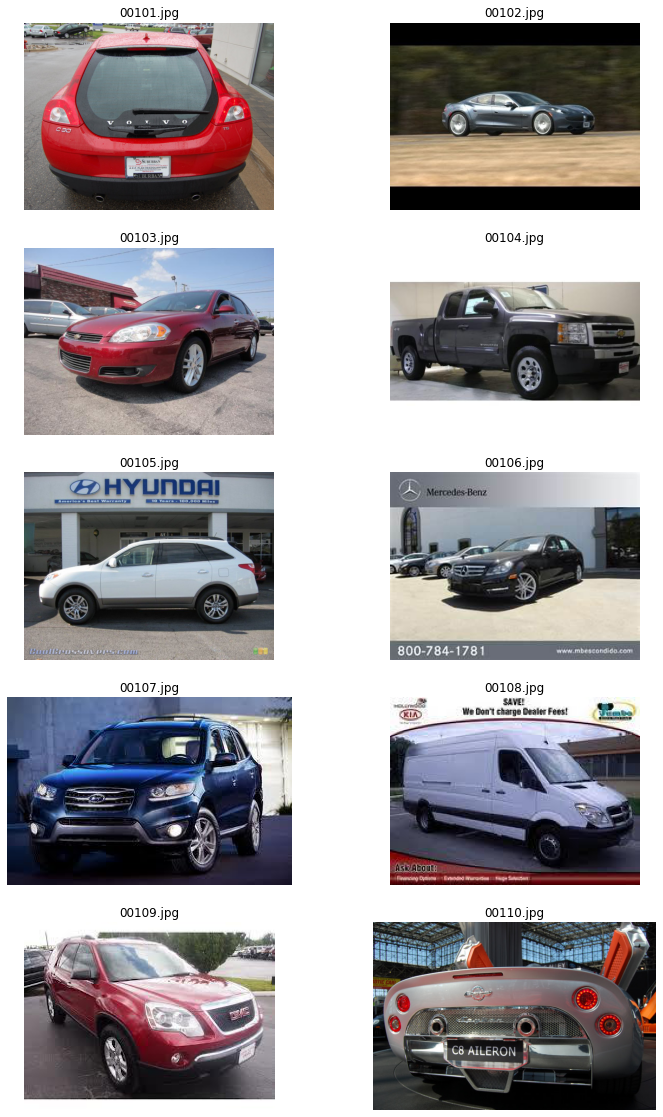

In [17]:
tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [18]:
## 박스 처리

def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

In [19]:
## train data 바운딩 처리

def make_boxing_img_train(img_name) :
    PATH = TRAIN_IMG_PATH
    data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

In [20]:
## test data 바운딩 처리

def make_boxing_img_test(img_name) :
    PATH = TEST_IMG_PATH
    data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

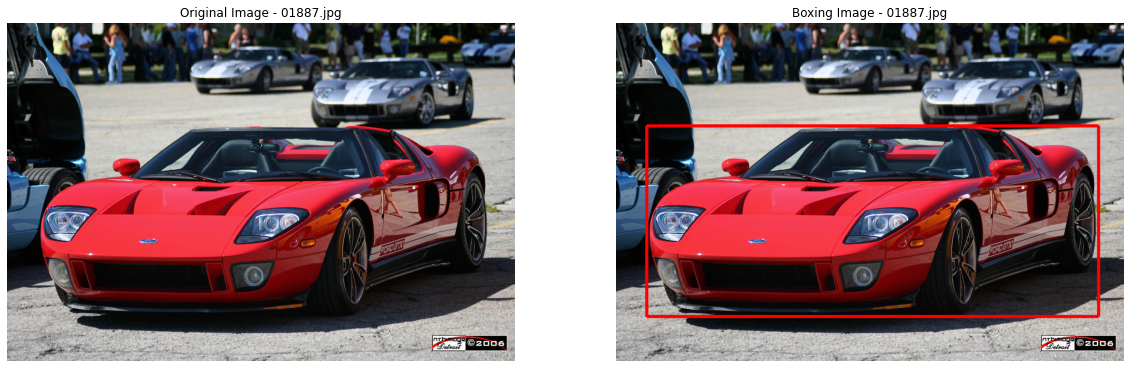

In [21]:
## 확인하고 싶은 이미지 번호 입력
f_name = "01887.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 2, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 2, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

## 이미지 resize 하기

In [22]:
## train 이미지 resize

def crop_resize_boxing_img_train(img_name, margin=16, size=(224, 224)) :
    PATH = TRAIN_IMG_PATH
    data = df_train
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [23]:
## test 이미지 resize

def crop_resize_boxing_img_test(img_name, margin=16, size=img_size) :
    PATH = TEST_IMG_PATH
    data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [24]:
# %%time
# ## 박스에 맞춰 이미지 resize (train data) 후 폴더에 저장

# for i, row in df_train.iterrows():
#     cropped = crop_resize_boxing_img_train(row['img_file'])
#     cropped.save(f"{'E:/coding/Stanford Cars Dataset/car_data/car_data/train_crop'}/{row['img_file']}")

In [25]:
# %%time
# ## 박스에 맞춰 이미지 resize (test data) 후 폴더에 저장

# for i, row in df_test.iterrows():
#     cropped = crop_resize_boxing_img_test(row['img_file'])
#     cropped.save(f"{'E:/coding/Stanford Cars Dataset/car_data/car_data/test_crop'}/{row['img_file']}")

In [26]:
## crop 이미지 경로 설정

TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop')
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop')

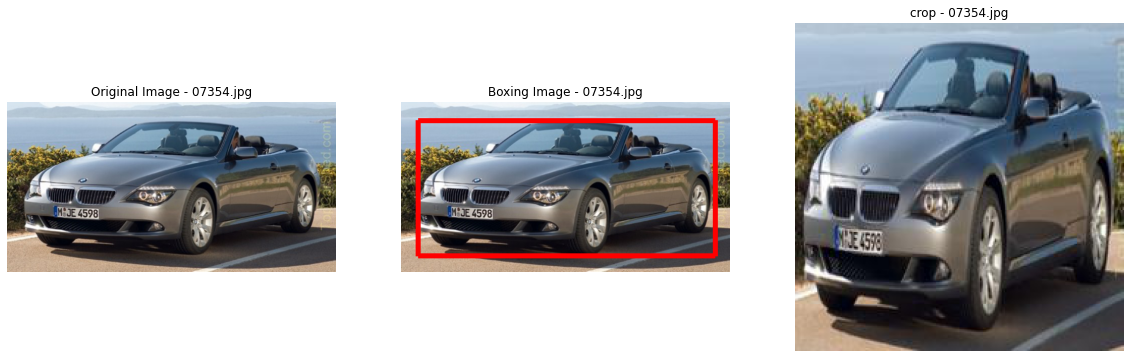

In [27]:
## 확인하고 싶은 이미지 번호 입력
f_name = "07354.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

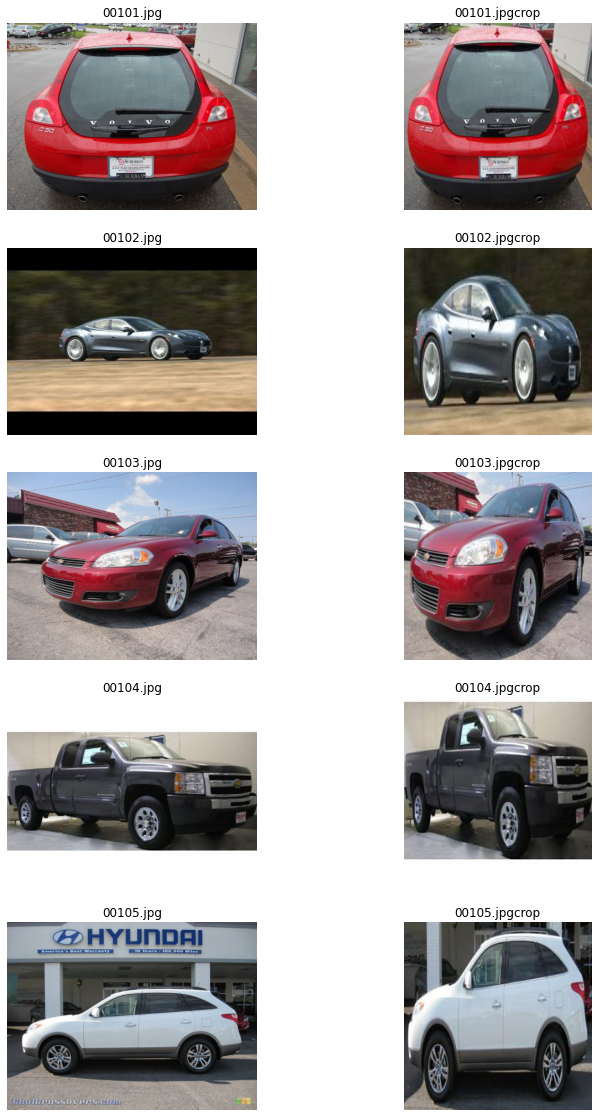

In [28]:
## crop 된 이미지 확인

tmp_imgs = df_train['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + "crop")
    plt.imshow(img)
    plt.axis('off')

## 모델링

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8144 non-null   object
 1   bbox_x1   8144 non-null   int64 
 2   bbox_y1   8144 non-null   int64 
 3   bbox_x2   8144 non-null   int64 
 4   bbox_y2   8144 non-null   int64 
 5   class     8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8041 non-null   object
 1   bbox_x1   8041 non-null   int64 
 2   bbox_y1   8041 non-null   int64 
 3   bbox_x2   8041 non-null   int64 
 4   bbox_y2   8041 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 314.2+ KB


In [31]:
## train, val, test set 나눠주기

from sklearn.model_selection import train_test_split

## class 를 string 으로 바꿔주고 좌표들을 지워준다.
df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(6515, 2)
(1629, 2)
(8041, 1)


모델링은 keras의 generator 들을 이용하면 쉽게 만들 수 있다.

In [32]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
## 데이터 제네레이터 구성하기

## 파라미터 설정
## https://keras.io/api/preprocessing/image/

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
batch_size = 32

## 입력이미지의 데이터 증강 (Data Augmentation)

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# val_datagen = ImageDataGenerator(rescale=1. / 255)
# train_datagen = ImageDataGenerator(rescale=1. / 255)

In [34]:
## 입력이미지의 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# val_datagen = ImageDataGenerator(rescale=1. / 255)
# train_datagen = ImageDataGenerator(rescale=1. / 255)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [35]:
## 제네레이터 설정
##.flow_from_dataframe
##.flow_from_directory

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_CROP_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROP_PATH,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames.


In [37]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import ResNet50V2

In [38]:
## MobileNet 으로  base model을 만든다.

# weights='imagenet' : 이미지 넷에 트레이닝 된 모델을 불러옴

IMG_SHAPE = img_size + (3, )

BaseModel = MobileNet(weights='imagenet', include_top=False)

# BaseModel = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# BaseModel = ResNet50V2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

model = Sequential()
model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               200900    
Total params: 3,429,764
Trainable params: 3,407,876
Non-trainable params: 21,888
_________________________________________________________________


In [39]:
## 모델 컴파일 하기
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [40]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [41]:
## 체크포인트 설정

## monitor : val_acc 를 기준으로 저장한다.
## verbose : 1 일 경우 모델이 저장 됨을 표시

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_mobilenet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
#es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [checkpoint]

In [153]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=50,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1935: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
204/204 [==============================] - 60s 294ms/step - loss: 0.1797 - acc: 0.9454 - val_loss: 1.4902 - val_acc: 0.6888

Epoch 00001: val_acc did not improve from 0.77901
Epoch 2/50
204/204 [==============================] - 61s 296ms/step - loss: 0.1663 - acc: 0.9466 - val_loss: 1.2873 - val_acc: 0.7225

Epoch 00002: val_acc did not improve from 0.77901
Epoch 3/50
204/204 [==============================] - 61s 300ms/step - loss: 0.1879 - acc: 0.9450 - val_loss: 1.0890 - val_acc: 0.7538

Epoch 00003: val_acc did not improve from 0.77901
Epoch 4/50
204/204 [==============================] - 64s 311ms/step - loss: 0.1311 - acc: 0.9601 - val_loss: 1.2522 - val_acc: 0.7489

Epoch 00004: val_acc did not improve from 0.77901
Epoch 5/50
204/204 [==============================] - 62s 303ms/step - loss: 0.1344 - acc: 0.9581 - val_loss: 1.3031 - val_acc: 0.7348

Epoch 00005: val_acc did not improve from 0.77901
Epoch 6/50
204/204 [==============================] - 63s 307ms/step -

33959

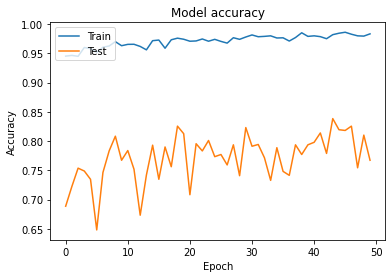

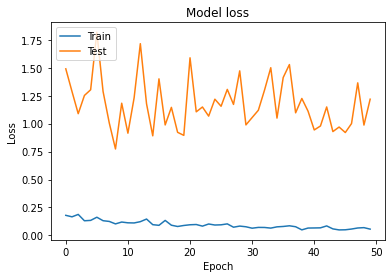

In [154]:
## 트레이닝 결과 곡선

## validation acc 곡선 그래프
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## validation loss 곡선 그래프
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
## 저장된 모델 리스트 정렬

model_list = sorted([i for i in os.listdir() if "my_" in i])
model_list

['my_mobilenet_model_0.78_1.0059.h5',
 'my_mobilenet_model_0.81_0.7733.h5',
 'my_mobilenet_model_0.83_0.9224.h5',
 'my_mobilenet_model_0.84_0.9290.h5']

In [43]:
## BEST Model 선택

model.load_weights(model_list[-1])

In [44]:
%%time
## Best Model 적용

test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1996: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


252/252 [==============================] - 14s 47ms/step
Wall time: 14.2 s


In [45]:
## 결과를 표로 작성

predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,00001.jpg,181
1,00002.jpg,103
2,00003.jpg,145
3,00004.jpg,187
4,00005.jpg,185


## 확인작업

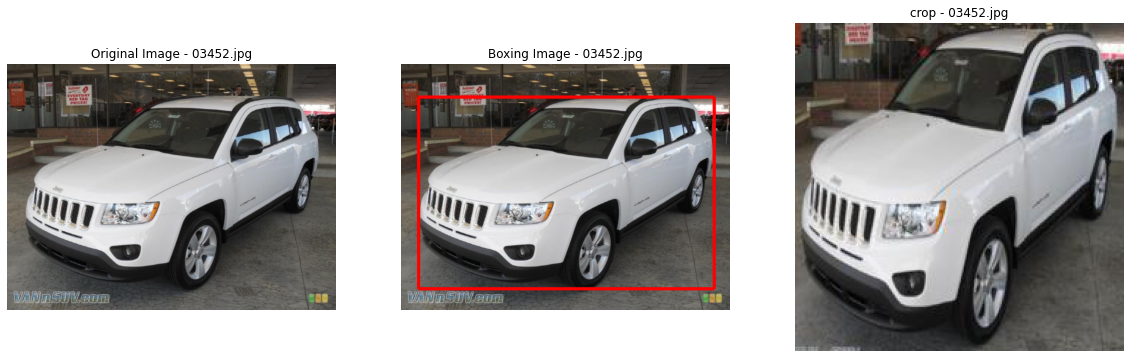

In [49]:
## test 이미지 확인
f_name = "03452.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TEST_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_test(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TEST_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

In [50]:
## 분류한 이미지의 추정 class 와 모델
## id = 추정 class 
## name 추정 모델 명

as1 = submission[submission['img_file'] == f_name]
df_class[df_class['id'] == int(as1.iloc[0][1])]

,id,name
148,149,Jeep Compass SUV 2012


In [51]:
as1

,img_file,class
3451,03452.jpg,149


# 간략 평가

In [52]:
EVAL_PATH = 'E:/coding/Stanford Cars Dataset'

all100 = pd.read_csv(os.path.join(EVAL_PATH, 'test_class.csv'))
all100 = all100[['img_file', 'class']]

In [53]:
score = []
for i in range(0,8040):
    if int(all100['class'][i]) == int(submission['class'][i]) :
        score.append(1)
    else:
        score.append(0)
print('정확도 : ' , score.count(1)/8040)
print('맞은 갯수 : ' , score.count(1), ' / 8040')
print('안맞은 갯수 : ',score.count(0))

정확도 :  0.8259950248756219
맞은 갯수 :  6641  / 8040
안맞은 갯수 :  1399


## 각 class 별 정확도 확인

In [251]:
classlist = pd.read_csv(os.path.join(EVAL_PATH, 'class.csv'))

In [247]:
totalclass = pd.read_csv(os.path.join(EVAL_PATH, 'totalclass.csv'))

In [125]:
totalclass = totalclass.sort_values(by=["class"], ascending=[True])
totalclass

,img_file,class,class1,a1
4116,04117.jpg,1,1,1
3245,03246.jpg,1,1,1
1198,01199.jpg,1,1,1
8034,08035.jpg,1,1,1
75,00076.jpg,1,1,1
...,...,...,...,...
932,00933.jpg,196,196,1
621,00622.jpg,196,110,0
5965,05966.jpg,196,196,1
5722,05723.jpg,196,196,1


In [258]:
model_rate = pd.read_csv(os.path.join(EVAL_PATH, 'model_rate.csv'))
model_rate

,id,model,rate
0,71,Chevrolet Express Van 2007,0.057143
1,10,Aston Martin Virage Convertible 2012,0.333333
2,14,Audi TTS Coupe 2012,0.333333
3,104,Ferrari 458 Italia Coupe 2012,0.452381
4,23,Audi S4 Sedan 2012,0.461538
...,...,...,...
163,130,Hyundai Veloster Hatchback 2012,1.000000
164,141,Infiniti G Coupe IPL 2012,1.000000
165,152,Lamborghini Gallardo LP 570 4 Superleggera 2012,1.000000
166,154,Land Rover Range Rover SUV 2012,1.000000


In [263]:
## 50% 미만 class
model_rate[model_rate['rate'] < 0.5]

,id,model,rate
0,71,Chevrolet Express Van 2007,0.057143
1,10,Aston Martin Virage Convertible 2012,0.333333
2,14,Audi TTS Coupe 2012,0.333333
3,104,Ferrari 458 Italia Coupe 2012,0.452381
4,23,Audi S4 Sedan 2012,0.461538


In [259]:
# for i in range(1,169):
#     print(i, classlist['name'][i-1],'-', totalclass[totalclass['class'] == i]['a1'].sum() / totalclass[totalclass['class'] == i]['class'].count())
#     i+=i

In [ ]:
"""
참고

캐글 차분류 : https://www.kaggle.com/c/2019-3rd-ml-month-with-kakr/overview


3등 : https://www.kaggle.com/seriousran/cutout-augmentation-on-keras-efficientnet
    
배경제거 : https://www.kaggle.com/cruiserx/3rd-ml-month-car-image-segmentation-crop
        
주 카피 : https://www.kaggle.com/daehungwak/keras-how-to-use-pretrained-model
        
로우 카피 : https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline
"""

---
---
---
추가로 직쩝 찍은 사진과, 국내 중고차 사진을 라벨링하여 모델에 돌려 보았다 시간 관계상 작은 숫자의 샘플밖에 실행하지 못하였다.

실제로 돌려작업을 해보려 하였다


## 추가 파일 확인

In [55]:
N_TEST = os.path.join(DATA_PATH, 'test_dj')
n_test = pd.read_csv(os.path.join(DATA_PATH, 'test_dj.csv'))

In [56]:
n_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [57]:
nb_n_test_samples = len(n_test)

In [58]:
n_test_generator = n_test_datagen.flow_from_dataframe(
    dataframe=n_test,
    directory=N_TEST,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 57 validated image filenames.


In [59]:
%%time
## Best Model 적용

n_test_generator.reset()
prediction = model.predict_generator(
    generator = n_test_generator,
    steps = get_steps(nb_n_test_samples, batch_size),
    verbose=1
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1996: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2/2 [==============================] - 1s 354ms/step
Wall time: 1.04 s


## 추가 결과표 작성

In [60]:
## 결과를 표로 작성

predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission2 = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission2.csv'))
submission2["class"] = predictions
submission2.to_csv("submission2.csv", index=False)
submission2.head()

,img_file,class
0,001.jpg,132
1,002.jpg,49
2,003.jpg,132
3,004.jpg,132
4,005.jpg,7


## 간략평가

In [61]:
#EVAL_PATH = 'E:/coding/Stanford Cars Dataset'

all1000 = pd.read_csv(os.path.join(EVAL_PATH, 'test_dj_class.csv'))
all1000 = all1000[['img_file', 'class']]

In [62]:
score1 = []
for i in range(0,57):
    if int(all1000['class'][i]) == int(submission2['class'][i]) :
        score1.append(1)
    else:
        score1.append(0)
print('정확도 : ' , score1.count(1)/57)
print('맞은 갯수 : ' , score1.count(1), ' / 57')
print('안맞은 갯수 : ',score1.count(0))

정확도 :  0.3333333333333333
맞은 갯수 :  19  / 57
안맞은 갯수 :  38
